In [2]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd

from pimpa.market_data_objects.curve import Curve
from pimpa.scenario_generation.brownian_motion import BrownianMotion
from pimpa.scenario_generation.geometric_brownian_motion import GeometricBrownianMotion
from pimpa.scenario_generation.hw1f import HW1F
from pimpa.utils.calendar_utils import generate_simulation_dates_schedule,transform_dates_to_time_differences
from pimpa.utils.notebook_tools import test_rfe_mean_and_vola, plot_rfe_paths, simulate_single_risk_factor
from pimpa.market_data_objects.market_data_builder import MarketDataBuilder
from data.configuration.global_parameters import global_parameters
from pimpa.data_objects.simulated_hw1f_curve import SimulatedHW1FCurve
from pimpa.market_data_objects.correlation_matrix import CorrelationMatrix
from pimpa.scenario_generation.multi_risk_factor_simulation import MultiRiskFactorSimulation
from pimpa.utils.notebook_tools import test_scenarios_marginal_distributions, test_scenarios_correlations


## Overall preparation

The below apply throughout the notebook:
1) We manually create a simulation grid 
2) We source the number of simulated paths from configuration

In [3]:
starting_date = '2010-01-01'
final_date = '2020-01-01'
valuation_frequency = 'monthly'
nr_paths = global_parameters['n_paths']
simulation_dates = generate_simulation_dates_schedule(starting_date, final_date, valuation_frequency, global_parameters)
print('-----------------------------')
print(simulation_dates)
print('-----------------------------')

-----------------------------
[datetime.datetime(2010, 1, 1, 0, 0) datetime.datetime(2010, 2, 1, 0, 0)
 datetime.datetime(2010, 3, 1, 0, 0) datetime.datetime(2010, 4, 1, 0, 0)
 datetime.datetime(2010, 5, 1, 0, 0) datetime.datetime(2010, 6, 1, 0, 0)
 datetime.datetime(2010, 7, 1, 0, 0) datetime.datetime(2010, 8, 1, 0, 0)
 datetime.datetime(2010, 9, 1, 0, 0) datetime.datetime(2010, 10, 1, 0, 0)
 datetime.datetime(2010, 11, 1, 0, 0) datetime.datetime(2010, 12, 1, 0, 0)
 datetime.datetime(2011, 1, 1, 0, 0) datetime.datetime(2011, 2, 1, 0, 0)
 datetime.datetime(2011, 3, 1, 0, 0) datetime.datetime(2011, 4, 1, 0, 0)
 datetime.datetime(2011, 5, 1, 0, 0) datetime.datetime(2011, 6, 1, 0, 0)
 datetime.datetime(2011, 7, 1, 0, 0) datetime.datetime(2011, 8, 1, 0, 0)
 datetime.datetime(2011, 9, 1, 0, 0) datetime.datetime(2011, 10, 1, 0, 0)
 datetime.datetime(2011, 11, 1, 0, 0) datetime.datetime(2011, 12, 1, 0, 0)
 datetime.datetime(2012, 1, 1, 0, 0) datetime.datetime(2012, 2, 1, 0, 0)
 datetime.datet

## GBM model

1) We construct a GBM model using the RiskFactorEvolution child class GeometricBrownianMotion
2) As as first attempt, we introduce an arbitrary RF ('RF_GBM_1') and create the market data / calibration data input manually
3) We rely on inspection tools to visualize the simulated paths and distributional moments through time

-----------------------------
RF_GBM_1 with 1 risk drivers
 Geometric Brownian Motion
 - drift: -0.2
 - volatility: 0.4
 - initial_value: 4
-----------------------------
{'RFE_GBM_calibration': {'RF_GBM_1': {'initial_value': 4, 'drift': -0.2, 'volatility': 0.4}}}
-----------------------------


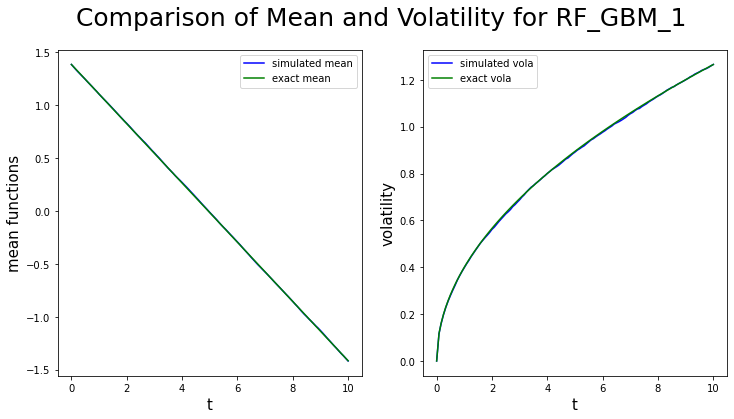

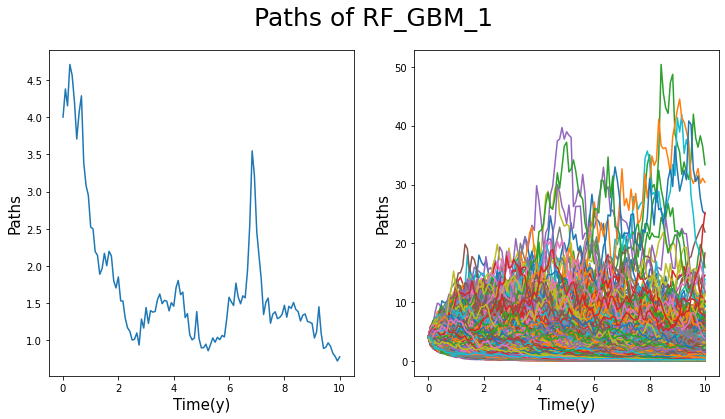

In [4]:
S_GBM = GeometricBrownianMotion('RF_GBM_1')

market_data = {
    'RFE_GBM_calibration': {
        'RF_GBM_1': {
            'initial_value': 4,
            'drift': -0.2,
            'volatility': 0.4
        }
    }
}

calibration_parameters = {'RFE_GBM_calibration': {'RF_GBM_1': {'calibration_method': 'direct_input'}}}
S_GBM.calibrate(market_data=market_data, calibration_parameters=calibration_parameters)
print('-----------------------------')
print(S_GBM)
print('-----------------------------')
print(market_data)
print('-----------------------------')
paths = simulate_single_risk_factor(S_GBM, simulation_dates, nr_paths)
test_rfe_mean_and_vola(paths, simulation_dates, S_GBM)
plot_rfe_paths(paths, simulation_dates, S_GBM.name)

1) We construct a GBM model using the RiskFactorEvolution child class GeometricBrownianMotion
2) We now introduce a supported RFs and rely on the dependency process to source the market data from static files. Notice that we provide the calibration method (that happens to be different from the default one) and the calibration is fetched from file (rather than being market implied).

-----------------------------
CREDIT_SUISSE_SHARE with 1 risk drivers
 Geometric Brownian Motion
 - drift: 0.0053
 - volatility: 0.03
 - initial_value: 10.0
-----------------------------
{'RFE_GBM_calibration': {'CREDIT_SUISSE_SHARE': {'initial_value': 10.0, 'drift': 0.0053, 'volatility': 0.03}}}
-----------------------------


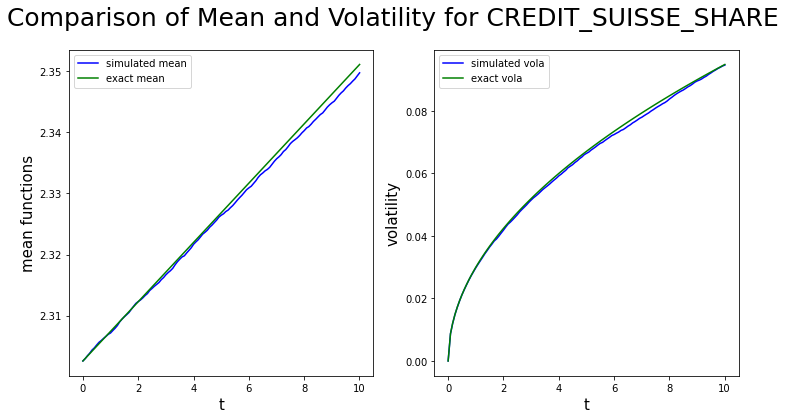

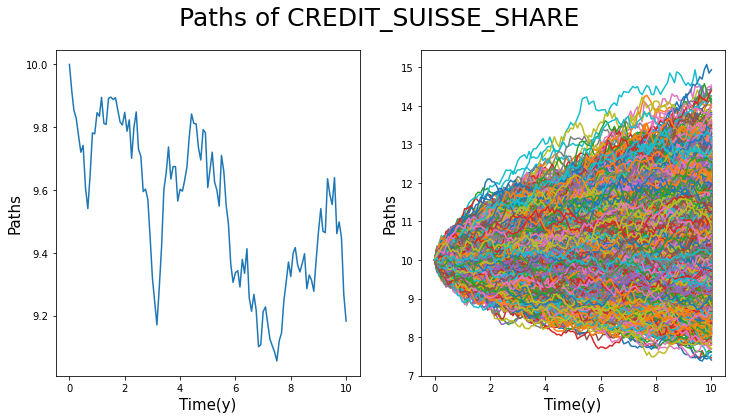

In [5]:
calibration_parameters = {'RFE_GBM_calibration': {'CREDIT_SUISSE_SHARE': {'calibration_method': 'direct_input'}}}
S_GBM = GeometricBrownianMotion('CREDIT_SUISSE_SHARE') # get data from the market database
RFE_dependencies=S_GBM.get_dependencies(calibration_parameters)
market_data=MarketDataBuilder().load_market_data(RFE_dependencies, global_parameters)
S_GBM.calibrate(market_data=market_data, calibration_parameters=calibration_parameters)
print('-----------------------------')
print(S_GBM)
print('-----------------------------')
print(market_data)
print('-----------------------------')
paths = simulate_single_risk_factor(S_GBM, simulation_dates, nr_paths)
test_rfe_mean_and_vola(paths, simulation_dates, S_GBM)
plot_rfe_paths(paths, simulation_dates, S_GBM.name)

1) We construct a GBM model using the RiskFactorEvolution child class GeometricBrownianMotion
2) We now introduce a supported RFs and rely on the dependency process to source the market data from static files. The calibration is the default one and market implied for the specific RF.

{('equity_spot', 'CREDIT_SUISSE_SHARE'), ('equity_implied_volatility_surface', 'CREDIT_SUISSE_IMPLIED_VOLATILITY_SURFACE')}
-----------------------------
CREDIT_SUISSE_SHARE with 1 risk drivers
 Geometric Brownian Motion
 - drift: 0
 - volatility: {0.019230769230769232: 0.45125, 0.08333333333333333: 0.361, 0.25: 0.27075, 1.0: 0.225625, 5.0: 0.1805}
 - initial_value: 10
-----------------------------
{'equity_spot': {'CREDIT_SUISSE_SHARE': {'spot': 10}}, 'equity_implied_volatility_surface': {'CREDIT_SUISSE_IMPLIED_VOLATILITY_SURFACE': <pimpa.market_data_objects.surface.Surface object at 0x7feeb845e790>}}
-----------------------------


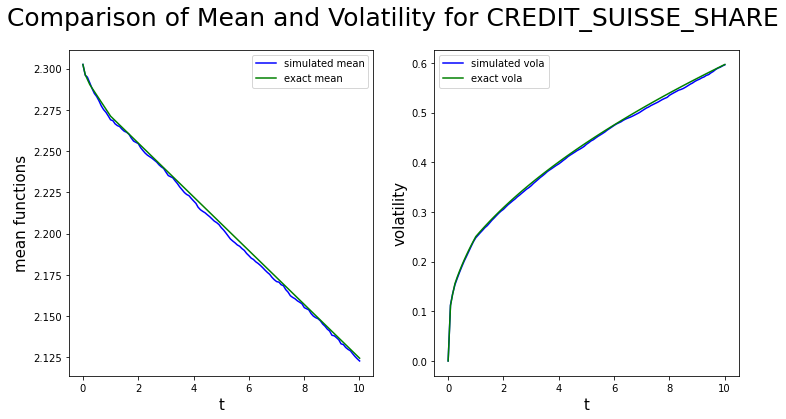

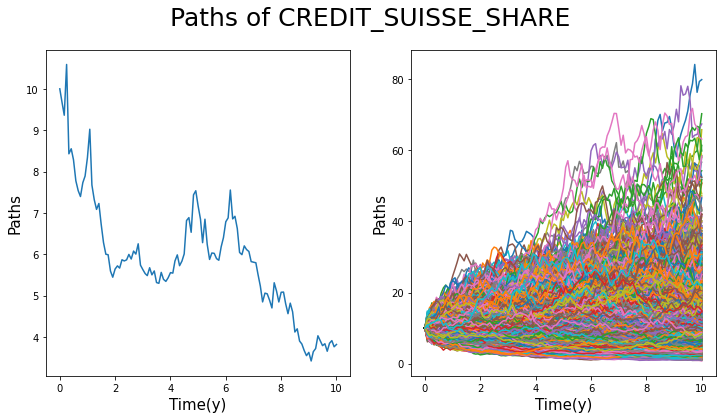

In [6]:
from data.configuration.global_parameters import calibration_parameters
S_GBM = GeometricBrownianMotion('CREDIT_SUISSE_SHARE')
RFE_dependencies=S_GBM.get_dependencies(calibration_parameters)
print(RFE_dependencies)
market_data=MarketDataBuilder().load_market_data(RFE_dependencies, global_parameters)
S_GBM.calibrate(market_data=market_data, calibration_parameters=calibration_parameters)
print('-----------------------------')
print(S_GBM)
print('-----------------------------')
print(market_data)
print('-----------------------------')
paths = simulate_single_risk_factor(S_GBM, simulation_dates, nr_paths)
test_rfe_mean_and_vola(paths, simulation_dates, S_GBM)
plot_rfe_paths(paths, simulation_dates, S_GBM.name)

1) In the latest (i.e. the default) approach, we calibrated the model using the implied volatility surface for the RFE
2) We look at the surface data and at the class Surface used to build the market data object

In [7]:
print('-----------------------------')
print(market_data['equity_implied_volatility_surface']['CREDIT_SUISSE_IMPLIED_VOLATILITY_SURFACE'].tenors)
print('-----------------------------')
print(market_data['equity_implied_volatility_surface']['CREDIT_SUISSE_IMPLIED_VOLATILITY_SURFACE'].strikes)
print('-----------------------------')
print(market_data['equity_implied_volatility_surface']['CREDIT_SUISSE_IMPLIED_VOLATILITY_SURFACE'].values)
print('-----------------------------')
print(market_data['equity_implied_volatility_surface']['CREDIT_SUISSE_IMPLIED_VOLATILITY_SURFACE'].interpolated_implied_vols(0.1,0.2))

-----------------------------
[0.01923077 0.08333333 0.25       1.         5.        ]
-----------------------------
[0.7 0.9 1.  1.1 1.3]
-----------------------------
[[0.5 0.4 0.3 0.25 0.2]
 [0.475 0.38 0.285 0.2375 0.19]
 [0.45125 0.361 0.27075 0.225625 0.1805]
 [0.4286875 0.34295 0.2572125 0.21434375 0.171475]
 [0.407253125 0.3258025 0.244351875 0.2036265625 0.16290125]]
-----------------------------
[0.39]


## Hull-White one-factor model (HW1F)

1) We construct a HW1F model using the RiskFactorEvolution child class HW1F
2) As as first attempt, we introduce an arbitrary RF ('RF_HW1F_1') and create the market data / calibration data input manually
3) We rely on inspection tools to visualize the simulated paths and distributional moments through time

-----------------------------
RF_HW1F_1 with 1 risk drivers
 1 Factor Hull White
 - alpha: 0.05
 - volatility: 0.01
-----------------------------
{'RFE_HW1F_calibration': {'RF_HW1F_1': {'rate_curve': <pimpa.market_data_objects.curve.Curve object at 0x7fee9ba1efd0>, 'alpha': 0.05, 'volatility': 0.01}}}
-----------------------------


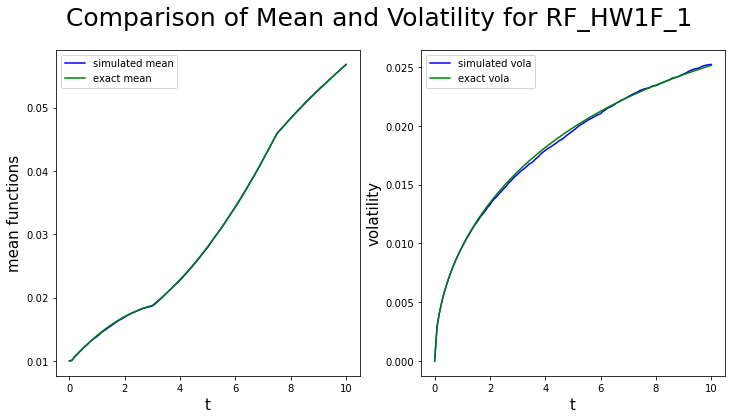

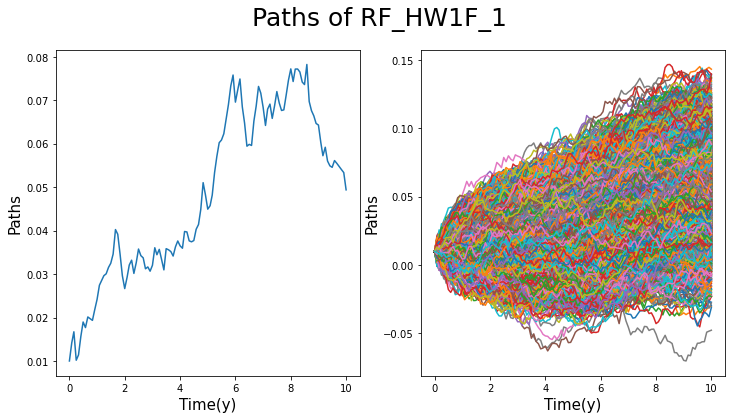

In [8]:
S_HW1F = HW1F('RF_HW1F_1') #choose a RF 

rate_curve = Curve({
    '1M': 0.01,
    '1Y': 0.012,
    '5Y': 0.018,
    '10Y': 0.03,
    '30Y': 0.05
}) 


#find dependencies 
#extract data 

market_data = {
    'RFE_HW1F_calibration': {
        'RF_HW1F_1': {
            'rate_curve': rate_curve,
            'alpha': 0.05,
            'volatility': 0.01
        }
    }
}
calibration_parameters = {'RFE_HW1F_calibration': {'RF_HW1F_1': {'calibration_method': 'direct_input'}}} 
S_HW1F.calibrate(market_data=market_data, calibration_parameters=calibration_parameters) #calibrate the model 
print('-----------------------------')
print(S_HW1F)
print('-----------------------------')
print(market_data)
print('-----------------------------')
paths = simulate_single_risk_factor(S_HW1F, simulation_dates, nr_paths) #run simulations with the model 
test_rfe_mean_and_vola(paths, simulation_dates, S_HW1F)
plot_rfe_paths(paths, simulation_dates, S_HW1F.name)

1) We construct a HW1F model using the RiskFactorEvolution child class HW1F
2) We now introduce a supported RFs and rely on the dependency process to source the market data from static files. Notice that we provide the calibration method (that happens to be different from the default one)

-----------------------------
USD_ZERO_YIELD_CURVE with 1 risk drivers
 1 Factor Hull White
 - alpha: 0.05
 - volatility: 0.01
-----------------------------
{'RFE_HW1F_calibration': {'USD_ZERO_YIELD_CURVE': {'alpha': 0.05, 'volatility': 0.01, 'rate_curve': <pimpa.market_data_objects.curve.Curve object at 0x7feec059e490>}}}
-----------------------------


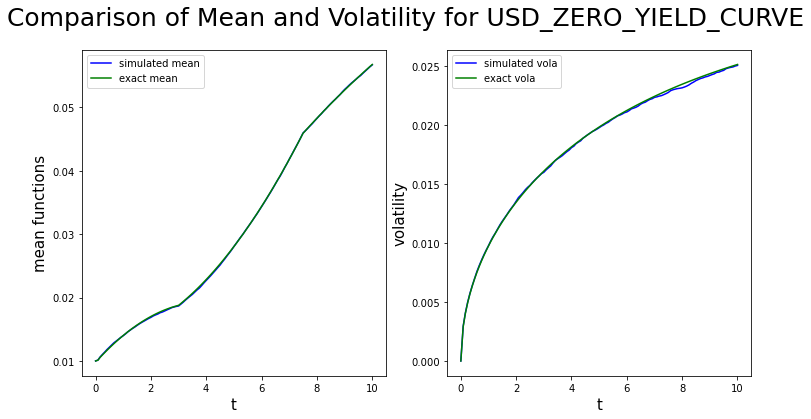

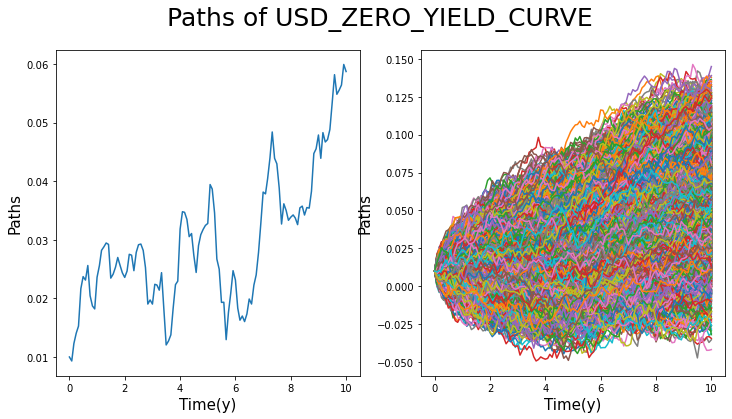

In [9]:
from data.configuration.global_parameters import calibration_parameters
S_HW1F = HW1F('USD_ZERO_YIELD_CURVE')
RFE_dependencies=S_HW1F.get_dependencies(calibration_parameters)
market_data=MarketDataBuilder().load_market_data(RFE_dependencies, global_parameters)
S_HW1F.calibrate(market_data=market_data, calibration_parameters=calibration_parameters)
print('-----------------------------')
print(S_HW1F)
print('-----------------------------')
print(market_data)
print('-----------------------------')
paths = simulate_single_risk_factor(S_HW1F, simulation_dates, nr_paths)
test_rfe_mean_and_vola(paths, simulation_dates, S_HW1F)
plot_rfe_paths(paths, simulation_dates, S_HW1F.name)

In [10]:
paths

,2010-01-01,2010-02-01,2010-03-01,2010-04-01,2010-05-01,2010-06-01,2010-07-01,2010-08-01,2010-09-01,2010-10-01,...,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01
0,0.01,0.009321,0.012296,0.014067,0.015274,0.021657,0.023724,0.023134,0.025620,0.020466,...,0.046707,0.047119,0.048848,0.053343,0.058202,0.054853,0.055556,0.056440,0.059944,0.058738
1,0.01,0.008481,0.008244,0.008734,0.011873,0.012348,0.008055,0.007190,0.012330,0.003460,...,0.081133,0.082819,0.085365,0.084687,0.087826,0.089642,0.085294,0.089644,0.090793,0.086953
2,0.01,0.013975,0.011428,0.019807,0.014872,0.016067,0.015221,0.014551,0.012576,0.014463,...,-0.002030,-0.008387,-0.004802,-0.005586,0.002641,-0.002413,0.001550,0.009635,0.015625,0.016109
3,0.01,0.009071,0.007051,0.008827,0.006491,0.004295,0.003237,-0.001565,-0.003804,-0.002504,...,0.019924,0.023199,0.020829,0.023062,0.026082,0.025785,0.025033,0.027395,0.031179,0.033521
4,0.01,0.007606,0.007933,0.006318,0.001966,0.003094,0.005729,0.003661,0.002217,0.008143,...,0.026587,0.028863,0.034259,0.033575,0.034380,0.032176,0.036361,0.038002,0.038591,0.036247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.01,0.008897,0.013952,0.016176,0.013631,0.012035,0.014469,0.012878,0.013266,0.014715,...,0.024289,0.021807,0.023112,0.027554,0.024372,0.023894,0.024217,0.025968,0.024691,0.025789
9996,0.01,0.008417,0.009763,0.014728,0.013003,0.013081,0.015621,0.019258,0.013630,0.015509,...,0.035817,0.032473,0.034597,0.032487,0.028566,0.026910,0.030357,0.031616,0.032870,0.030892
9997,0.01,0.006687,0.002985,0.003572,0.002860,0.002763,0.008079,0.008362,0.009798,0.013253,...,0.066283,0.068565,0.067612,0.066863,0.064209,0.063975,0.062252,0.061077,0.060807,0.060852
9998,0.01,0.006305,0.004406,0.004547,0.005796,0.003352,0.007420,0.008609,0.005709,0.007207,...,0.068309,0.067917,0.064972,0.065195,0.066060,0.067405,0.071144,0.067918,0.068446,0.068951


1) The simulation deliveres scenarios for the short rate
2) The HW framework can be used to derive future values for all tenors of the yield curve via the closed form solution for the bond prices
3) The transformation is managed by a dedicated class SimulatedHW1FCurve, where an object is constructed by providing a slice of simulated paths. SimulatedHW1FCurve is a child class of SimulatedData (that is meant for factor models that require a M to N mapping)

In [11]:
print('-----------------------------')
print('t=0, no stochasticity, tenors=1m, 1y, 5y')
HW1F_transformation=SimulatedHW1FCurve(paths.to_numpy()[:,0])
print('-----------------------------')
print(-np.log(HW1F_transformation.get_value(calibration=S_HW1F.calibration,initial_date=None,t_date=0,T_date=0.0028))/0.0028)
print('-----------------------------')
print(-np.log(HW1F_transformation.get_value(calibration=S_HW1F.calibration,initial_date=None,t_date=0,T_date=1))/1)
print('-----------------------------')
print(-np.log(HW1F_transformation.get_value(calibration=S_HW1F.calibration,initial_date=None,t_date=0,T_date=5))/5)
print('t=1m, some stochasticity, tenors=1m, 1y, 5y') 
HW1F_transformation=SimulatedHW1FCurve(paths.to_numpy()[:,1])
print('-----------------------------')
print(-np.log(HW1F_transformation.get_value(calibration=S_HW1F.calibration,initial_date=None,t_date=0,T_date=0.0028))/0.0028)
print('-----------------------------')
print(-np.log(HW1F_transformation.get_value(calibration=S_HW1F.calibration,initial_date=None,t_date=0,T_date=1))/1)
print('-----------------------------')
print(-np.log(HW1F_transformation.get_value(calibration=S_HW1F.calibration,initial_date=None,t_date=0,T_date=5))/5)
print('-----------------------------')
print('t=1y, more stochasticity, tenors=1m, 1y, 5y') 
HW1F_transformation=SimulatedHW1FCurve(paths.to_numpy()[:,13])
print('-----------------------------')
print(-np.log(HW1F_transformation.get_value(calibration=S_HW1F.calibration,initial_date=None,t_date=0,T_date=0.0028))/0.0028)
print('-----------------------------')
print(-np.log(HW1F_transformation.get_value(calibration=S_HW1F.calibration,initial_date=None,t_date=0,T_date=1))/1)
print('-----------------------------')
print(-np.log(HW1F_transformation.get_value(calibration=S_HW1F.calibration,initial_date=None,t_date=0,T_date=5))/5)
print('-----------------------------')

-----------------------------
t=0, no stochasticity, tenors=1m, 1y, 5y
-----------------------------
[[0.01]
 [0.01]
 [0.01]
 ...
 [0.01]
 [0.01]
 [0.01]]
-----------------------------
[[0.012]
 [0.012]
 [0.012]
 ...
 [0.012]
 [0.012]
 [0.012]]
-----------------------------
[[0.018]
 [0.018]
 [0.018]
 ...
 [0.018]
 [0.018]
 [0.018]]
t=1m, some stochasticity, tenors=1m, 1y, 5y
-----------------------------
[[0.00932107]
 [0.00848084]
 [0.01397481]
 ...
 [0.00668737]
 [0.00630569]
 [0.00947179]]
-----------------------------
[[0.01133772]
 [0.01051809]
 [0.01587735]
 ...
 [0.00876859]
 [0.00839627]
 [0.01148475]]
-----------------------------
[[0.01739924]
 [0.01665576]
 [0.02151715]
 ...
 [0.01506879]
 [0.01473105]
 [0.01753261]]
-----------------------------
t=1y, more stochasticity, tenors=1m, 1y, 5y
-----------------------------
[[0.0256087 ]
 [0.00938369]
 [0.01228327]
 ...
 [0.01644278]
 [0.01355852]
 [0.01844696]]
-----------------------------
[[0.02722597]
 [0.0113988 ]
 [0.01422

## Multi-RFs scenarios

1) Construction of the (simulated) RFs objects out of the supported RFs provided
2) Construction of the market data via the dependencies process for all the RFs
3) Calibration of the RF models 
4) Load of the static correlation matrix (market data object of class CorrelationMatrix (inclusive or regularization)
5) Creation of a multiRiskFactorSimulation object (child class of ScenarioGenerator)
6) Generation of the MC scenarios via the method generate_scenarios

In [12]:
from data.configuration.global_parameters import calibration_parameters
#Simulated RFs objects
simulated_risk_factors = set(['USD_ZERO_YIELD_CURVE','CREDIT_SUISSE_SHARE'])
print('-----------------------------')
simulated_risk_factor_objects = MarketDataBuilder().get_risk_factors(simulated_risk_factors, global_parameters)
print(simulated_risk_factor_objects)
print('-----------------------------')
#Construction of the RFs market data
RFE_dependencies=set()
for RF in simulated_risk_factors:
    model=simulated_risk_factor_objects[RF].model
    RFE_dependencies.update(model.get_dependencies(calibration_parameters))

market_data=MarketDataBuilder().load_market_data(RFE_dependencies, global_parameters)
print(market_data) 
print('-----------------------------')
#Calibration of the RFs models 
_ = [rf.model.calibrate(market_data, calibration_parameters) for rf in simulated_risk_factor_objects.values()]
print(simulated_risk_factor_objects['USD_ZERO_YIELD_CURVE'].model)
print('-----------------------------')
print(simulated_risk_factor_objects['CREDIT_SUISSE_SHARE'].model)
print('-----------------------------')
#Load the correlation matrix
correlation_matrix = CorrelationMatrix(file_path = global_parameters['prototype_data_paths']['RFE'] + \
                                       global_parameters['prototype_data_files']['RFE']['RFE_correlation_matrix'])
print(correlation_matrix.correlation_matrix)
print('-----------------------------')
scenario_object = MultiRiskFactorSimulation(simulated_risk_factor_objects.values(), correlation_matrix)
simulated_scenarios=scenario_object.generate_scenarios(simulation_dates, global_parameters)

-----------------------------
{'USD_ZERO_YIELD_CURVE': RiskFactor(name='USD_ZERO_YIELD_CURVE', asset_class='IR', asset_type='DISCOUNT_CURVE', currency='USD', simulated=True, model=<pimpa.scenario_generation.hw1f.HW1F object at 0x7fee9d981fd0>, model_name='HW1F', reference=None), 'CREDIT_SUISSE_SHARE': RiskFactor(name='CREDIT_SUISSE_SHARE', asset_class='EQ', asset_type='SPOT', currency='USD', simulated=True, model=<pimpa.scenario_generation.geometric_brownian_motion.GeometricBrownianMotion object at 0x7fee9d981d90>, model_name='GBM', reference=None)}
-----------------------------
{'equity_spot': {'CREDIT_SUISSE_SHARE': {'spot': 10}}, 'RFE_HW1F_calibration': {'USD_ZERO_YIELD_CURVE': {'alpha': 0.05, 'volatility': 0.01, 'rate_curve': <pimpa.market_data_objects.curve.Curve object at 0x7fee9d981d30>}}, 'equity_implied_volatility_surface': {'CREDIT_SUISSE_IMPLIED_VOLATILITY_SURFACE': <pimpa.market_data_objects.surface.Surface object at 0x7feed9140ee0>}}
-----------------------------
USD_ZERO_

In [13]:
RFE_dependencies

{('RFE_HW1F_calibration', 'USD_ZERO_YIELD_CURVE'),
 ('equity_implied_volatility_surface',
  'CREDIT_SUISSE_IMPLIED_VOLATILITY_SURFACE'),
 ('equity_spot', 'CREDIT_SUISSE_SHARE')}

In [14]:
market_data

{'equity_spot': {'CREDIT_SUISSE_SHARE': {'spot': 10}},
 'RFE_HW1F_calibration': {'USD_ZERO_YIELD_CURVE': {'alpha': 0.05,
   'volatility': 0.01,
   'rate_curve': <pimpa.market_data_objects.curve.Curve at 0x7fee9d981d30>}},
 'equity_implied_volatility_surface': {'CREDIT_SUISSE_IMPLIED_VOLATILITY_SURFACE': <pimpa.market_data_objects.surface.Surface at 0x7feed9140ee0>}}

1) We perform a test from utils to check marginal distributions
2) We perform a test from utils to check correlation matrix

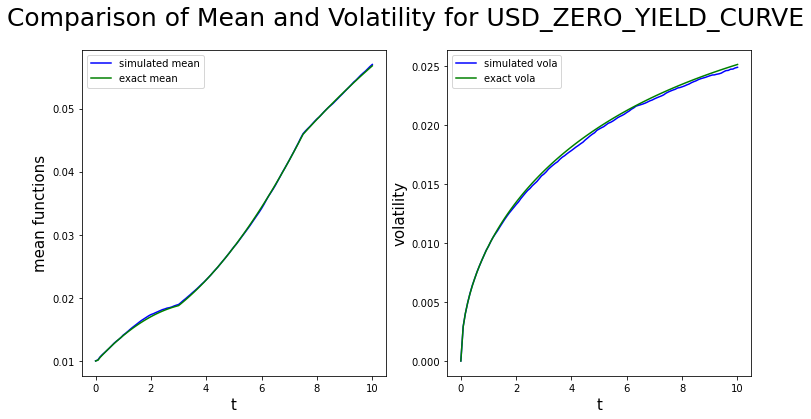

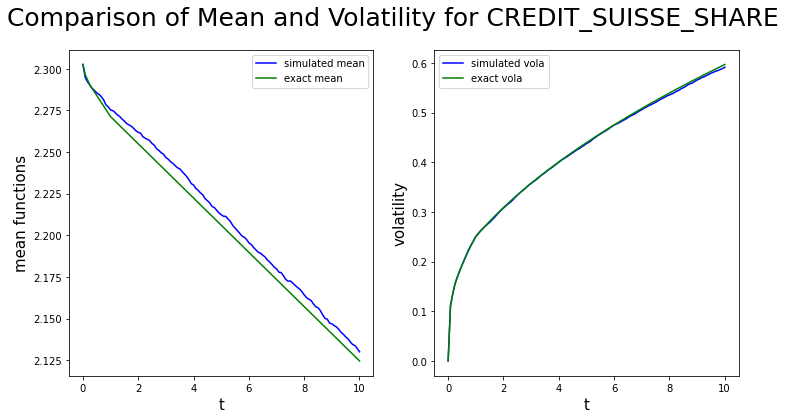

-----------------------------
The max observed error in correlations is 3.646561596224021e-05
-----------------------------
                                             realised_correlations  \
USD_ZERO_YIELD_CURVE_X_USD_ZERO_YIELD_CURVE               1.000000   
CREDIT_SUISSE_SHARE_X_USD_ZERO_YIELD_CURVE                0.000036   
CREDIT_SUISSE_SHARE_X_CREDIT_SUISSE_SHARE                 1.000000   

                                             true_correlations  
USD_ZERO_YIELD_CURVE_X_USD_ZERO_YIELD_CURVE                1.0  
CREDIT_SUISSE_SHARE_X_USD_ZERO_YIELD_CURVE                 0.0  
CREDIT_SUISSE_SHARE_X_CREDIT_SUISSE_SHARE                  1.0  
-----------------------------


In [15]:
test_scenarios_marginal_distributions(simulated_scenarios, scenario_object)
correlations, max_error = test_scenarios_correlations(simulated_scenarios, scenario_object, correlation_matrix)
print('-----------------------------')
print(f'The max observed error in correlations is {max_error}')
print('-----------------------------')
print(correlations)
print('-----------------------------')

In [16]:
from data.configuration.global_parameters import calibration_parameters
#Simulated RFs objects
simulated_risk_factors = set(['USD_ZERO_YIELD_CURVE'])
print('-----------------------------')
simulated_risk_factor_objects = MarketDataBuilder().get_risk_factors(simulated_risk_factors, global_parameters)
print(simulated_risk_factor_objects)
print('-----------------------------')
#Construction of the RFs market data
RFE_dependencies=set()
for RF in simulated_risk_factors:
    model=simulated_risk_factor_objects[RF].model
    RFE_dependencies.update(model.get_dependencies(calibration_parameters))

market_data=MarketDataBuilder().load_market_data(RFE_dependencies, global_parameters)
print(market_data) 
print('-----------------------------')
#Calibration of the RFs models 
_ = [rf.model.calibrate(market_data, calibration_parameters) for rf in simulated_risk_factor_objects.values()]
print(simulated_risk_factor_objects['USD_ZERO_YIELD_CURVE'].model)
print('-----------------------------')

#Load the correlation matrix
correlation_matrix = CorrelationMatrix(file_path = global_parameters['prototype_data_paths']['RFE'] + \
                                       global_parameters['prototype_data_files']['RFE']['RFE_correlation_matrix'])
print(correlation_matrix.correlation_matrix)
print('-----------------------------')
scenario_object = MultiRiskFactorSimulation(simulated_risk_factor_objects.values(), correlation_matrix)
simulated_scenarios=scenario_object.generate_scenarios(simulation_dates, global_parameters)

-----------------------------
{'USD_ZERO_YIELD_CURVE': RiskFactor(name='USD_ZERO_YIELD_CURVE', asset_class='IR', asset_type='DISCOUNT_CURVE', currency='USD', simulated=True, model=<pimpa.scenario_generation.hw1f.HW1F object at 0x7fee9d816e50>, model_name='HW1F', reference=None)}
-----------------------------
{'RFE_HW1F_calibration': {'USD_ZERO_YIELD_CURVE': {'alpha': 0.05, 'volatility': 0.01, 'rate_curve': <pimpa.market_data_objects.curve.Curve object at 0x7feecb153ca0>}}}
-----------------------------
USD_ZERO_YIELD_CURVE with 1 risk drivers
 1 Factor Hull White
 - alpha: 0.05
 - volatility: 0.01
-----------------------------
[[1.         0.9        0.9        0.2        0.1        0.
  0.         0.         0.        ]
 [0.9        1.         0.9        0.1        0.2        0.
  0.         0.         0.        ]
 [0.9        0.9        1.         0.1        0.1        0.
  0.         0.         0.        ]
 [0.2        0.1        0.1        1.         0.6        0.
  0.         0.  

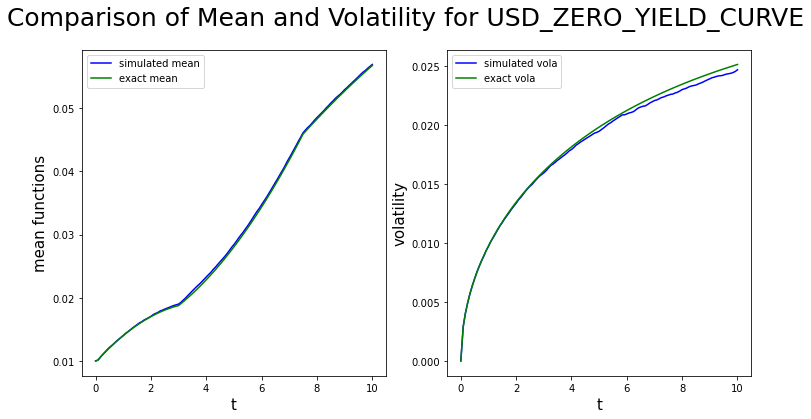

-----------------------------
The max observed error in correlations is 2.220446049250313e-16
-----------------------------
                                             realised_correlations  \
USD_ZERO_YIELD_CURVE_X_USD_ZERO_YIELD_CURVE                    1.0   

                                             true_correlations  
USD_ZERO_YIELD_CURVE_X_USD_ZERO_YIELD_CURVE                1.0  
-----------------------------


In [17]:
test_scenarios_marginal_distributions(simulated_scenarios, scenario_object)
correlations, max_error = test_scenarios_correlations(simulated_scenarios, scenario_object, correlation_matrix)
print('-----------------------------')
print(f'The max observed error in correlations is {max_error}')
print('-----------------------------')
print(correlations)
print('-----------------------------')